In [1]:
import os, shutil
import numpy as np

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train2 = os.path.join(base_dir, 'train2')
if not os.path.isdir(train2):
    os.mkdir(train2)

test2 = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

train2_cats = os.path.join(train2, 'cats')
if not os.path.isdir(train2_cats):
    os.mkdir(train2_cats)

train2_dogs = os.path.join(train2, 'dogs')
if not os.path.isdir(train2_dogs):
    os.mkdir(train2_dogs)

In [ ]:
origin_train_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/train'

filenames = ['cat.{}.jpg'.format(i) for i in range(12500)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(train2_cats, filename)
    shutil.copyfile(src, dst)
    
filenames = ['dog.{}.jpg'.format(i) for i in range(12500)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(train2_dogs, filename)
    shutil.copyfile(src, dst)

In [ ]:
from keras.models import Model,Input
from keras.layers import GlobalAveragePooling2D, Lambda 
from keras.applications import ResNet50, InceptionV3, Xception, resnet50, inception_v3, xception
from keras.preprocessing.image import ImageDataGenerator

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen = ImageDataGenerator()
    batch_size = 15
    
    train_generator = gen.flow_from_directory(train2, image_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    test_generator = gen.flow_from_directory(test2, image_size, shuffle=False, batch_size=batch_size, class_mode=None)
    
    train = np.zeros(shape=(25000, 2048))
    test = np.zeros(shape=(12500, 2048))
    label = np.zeros(shape=(25000,))
    
    i = 0
    j = 0
    for train_inputs_batch, train_labels_batch in train_generator:
        train_features_batch = model.predict(train_inputs_batch)
        train[i * batch_size : (i + 1) * batch_size] = train_features_batch
        label[i * batch_size : (i + 1) * batch_size] = train_labels_batch
        
        i += 1
        if i * batch_size >= 25000:
            break
    
    for test_inputs_batch in test_generator:
        test_features_batch = model.predict(test_inputs_batch)
        test[j * batch_size : (j + 1) * batch_size] = test_features_batch
        
        j += 1
        if j * batch_size >= 12500:
            break

    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:        
        h.create_dataset("train", data=train)
        h.create_dataset("label", data=label)
        h.create_dataset("test", data=test)
        
        
write_gap(ResNet50, (224, 224), resnet50.preprocess_input)
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)

In [3]:
from sklearn.utils import shuffle
#np.random.seed(2018)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)

X_train, y_train = shuffle(X_train, y_train)

(25000, 6144)
(12500, 6144)
(25000,)


In [4]:
from keras.models import Input, Model
from keras.layers import Dropout, Dense
from keras import optimizers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
#x = Dense(1536, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [5]:
history = model.fit(X_train, y_train, batch_size=100, epochs =12, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 2s 82us/step - loss: 0.0644 - acc: 0.9787 - val_loss: 0.0178 - val_acc: 0.9930
Epoch 2/12
20000/20000 [==============================] - 1s 33us/step - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0185 - val_acc: 0.9922
Epoch 3/12
20000/20000 [==============================] - 1s 34us/step - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 4/12
20000/20000 [==============================] - 1s 37us/step - loss: 0.0141 - acc: 0.9952 - val_loss: 0.0148 - val_acc: 0.9932
Epoch 5/12
20000/20000 [==============================] - 1s 40us/step - loss: 0.0135 - acc: 0.9954 - val_loss: 0.0161 - val_acc: 0.9944
Epoch 6/12
20000/20000 [==============================] - 1s 38us/step - loss: 0.0119 - acc: 0.9959 - val_loss: 0.0162 - val_acc: 0.9944
Epoch 7/12
20000/20000 [==============================] - 1s 38us/step - loss: 0.0110 - acc: 0.9961 - val_loss: 0.0147 - val_acc:

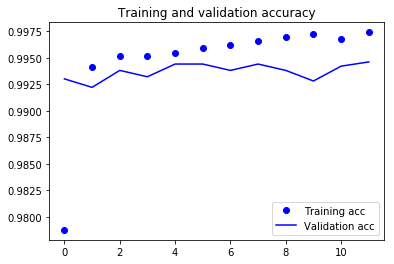

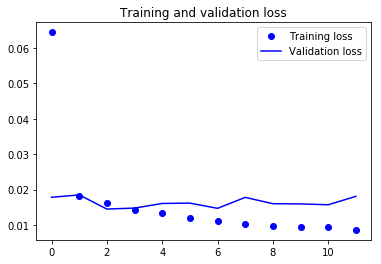

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)
y_pred = y_pred.reshape(12500,)

12500/12500 [==============================] - 0s 35us/step


In [9]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator()

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=100,
        class_mode=None,
        shuffle=False)

id_batch = test_generator.filenames
print(id_batch[:10])

Found 12500 images belonging to 1 classes.
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [10]:
from tqdm import tqdm

with open('Feature_Integration.csv','w') as f:
    f.write('id,label\n')
    
with open('Feature_Integration.csv','a') as f:
    i = 0
    for img_label in tqdm(y_pred):
        img_name = id_batch[i]
        img_id = int(img_name[img_name.rfind('/')+1:img_name.rfind('.')])
        f.write('{},{}\n'.format(img_id,img_label))
        i+=1

100%|██████████| 12500/12500 [00:00<00:00, 323321.23it/s]
